# Bayesian Switchpoint Analysis: Wikimedia Page Views

In this example, Bayesian Switchpoint Analysis is used in order to detect a point of significant change in page views for the term "vacation" according to [Wikimedia Toolforge](https://pageviews.toolforge.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-06-13&end=2020-07-03&pages=vacation).

The purpose of this analysis is to 1) identify the switch point, or the point at which page views for the term "vacation" see a significant drop, and 2) generate the pre and post-COVID posterior samples.

The model is assuming the onset of COVID-19 as the switch point, i.e. the time during which page views drop significantly.

**Attributions**

The below code uses the template from the [Bayesian Switchpoint Analysis](https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis#prerequisites) tutorial, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on the vacation time series dataset - the original dataset used was the [UK coal mining disaster time series](https://pymc-devs.github.io/pymc/tutorial.html#two-types-of-variables). The original source code can be found [here](https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Switchpoint_Analysis.ipynb).

The original datasets for hotel cancellations, as well as relevant research, is available here from the original authors.

* [Antonio, Almeida, Nunes, 2019. Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191)

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Import Libraries

In [2]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

### Load Data

In [3]:
train_df = pd.read_csv("pageviews-20190101-20201110.csv")

In [4]:
train_df

Date  Vacation
0    2019-01-01       247
1    2019-01-02       358
2    2019-01-03       400
3    2019-01-04       338
4    2019-01-05       276
..          ...       ...
675  2020-11-06       185
676  2020-11-07       121
677  2020-11-08       161
678  2020-11-09       146
679  2020-11-10       179

[680 rows x 2 columns]

In [5]:
tseries=train_df['Vacation']
tseries

0      247
1      358
2      400
3      338
4      276
      ... 
675    185
676    121
677    161
678    146
679    179
Name: Vacation, Length: 680, dtype: int64

In [6]:
vacation_data = np.array(tseries)
vacation_data

array([247, 358, 400, 338, 276, 314, 428, 386, 342, 395, 293, 251, 285,
       326, 299, 311, 323, 255, 223, 284, 295, 253, 287, 311, 234, 187,
       240, 311, 270, 286, 295, 278, 227, 235, 267, 262, 261, 261, 265,
       198, 278, 301, 354, 403, 283, 319, 242, 220, 332, 332, 385, 323,
       301, 223, 220, 307, 315, 324, 383, 301, 268, 275, 312, 422, 368,
       325, 284, 244, 334, 345, 322, 289, 379, 335, 350, 384, 364, 310,
       334, 347, 375, 285, 266, 308, 344, 399, 339, 280, 265, 256, 328,
       290, 365, 312, 307, 253, 292, 409, 277, 288, 305, 359, 245, 251,
       342, 277, 304, 341, 357, 236, 252, 311, 289, 337, 352, 299, 308,
       423, 307, 315, 303, 301, 297, 274, 283, 636, 384, 384, 321, 293,
       274, 295, 336, 313, 286, 322, 336, 255, 274, 320, 410, 447, 342,
       338, 276, 305, 393, 396, 360, 369, 311, 344, 328, 368, 350, 373,
       346, 323, 282, 357, 408, 423, 374, 339, 355, 297, 325, 404, 379,
       412, 405, 360, 257, 316, 433, 440, 392, 382, 365, 271, 38

Data is converted to logarithmic format to smooth out the volatility in the series.

In [7]:
vacation_data=np.log(vacation_data)

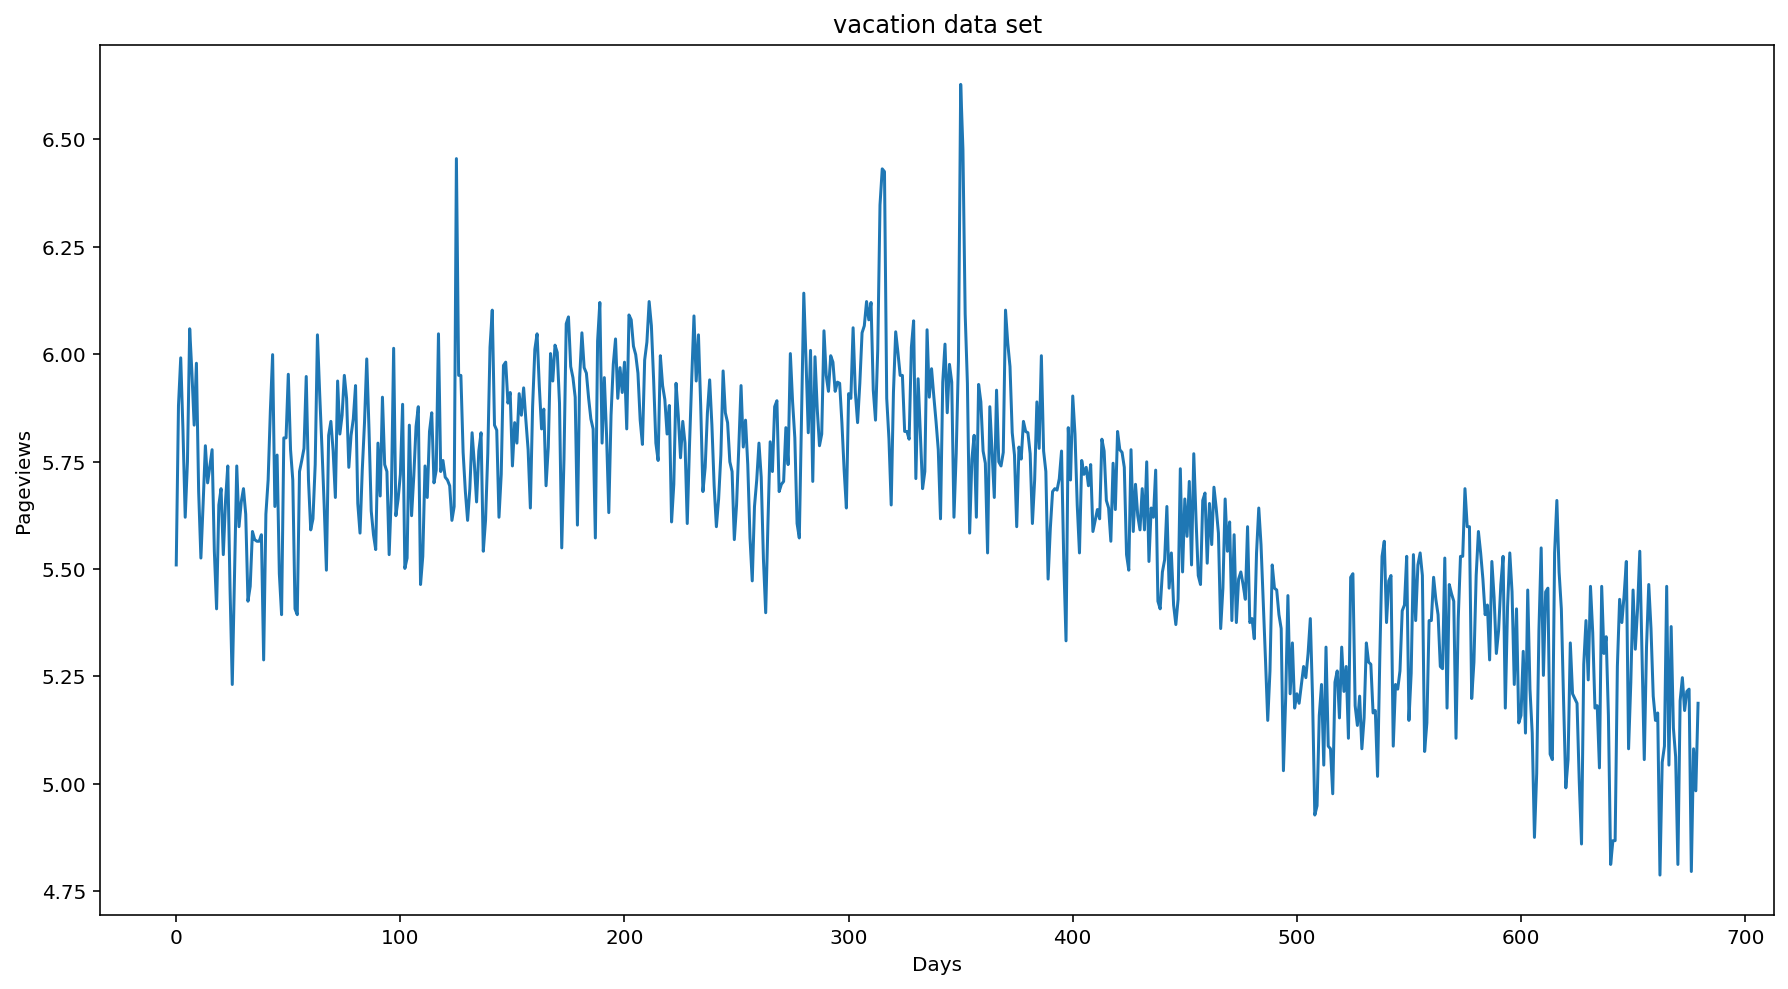

In [8]:
date=np.arange(0,680)
plt.plot(vacation_data)
plt.ylabel('Pageviews')
plt.xlabel('Days')
plt.title('vacation data set')
plt.show()

### Probability Distribution

In [9]:
def vacation_count_model(vacation_rate_fn):
  vacation_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(date)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=vacation_rate_fn(np.arange(len(date)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return vacation_count

def vacation_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l)

def vacation_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = vacation_count_model(vacation_rate_switch)
model_sigmoid = vacation_count_model(vacation_rate_sigmoid)

In [10]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=vacation_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-4851.344, -4844.71]
[-1573.236, -1568.2692]
[-inf, -inf]


### Simulation: Results and Burn-In Defined

In [11]:
num_results = 10000
num_burnin_steps = 0

@tf.function(autograph=False, experimental_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          tfb.Sigmoid(low=0., high=tf.cast(len(date), dtype=tf.float32)),
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_pre_covid_rate'),
          tf.ones([], name='init_post_covid_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, pre_covid_rate, post_covid_rate = zip(
    switch_samples, sigmoid_samples)

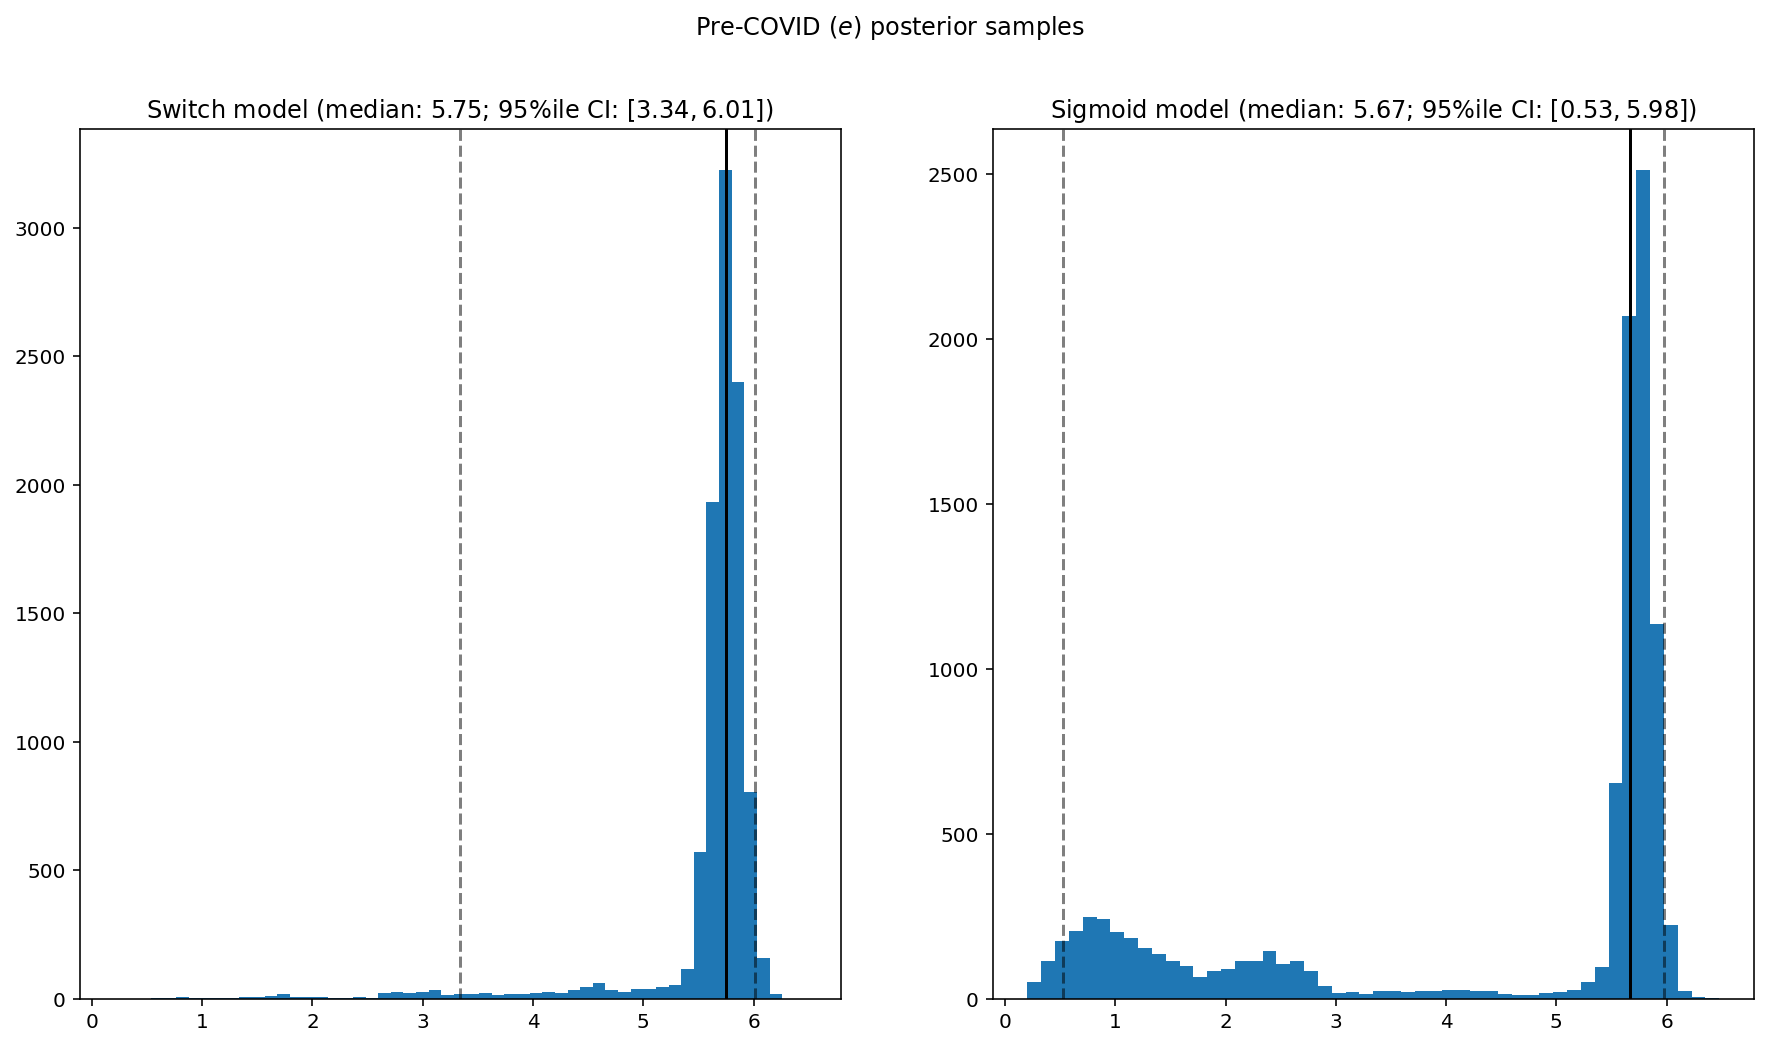

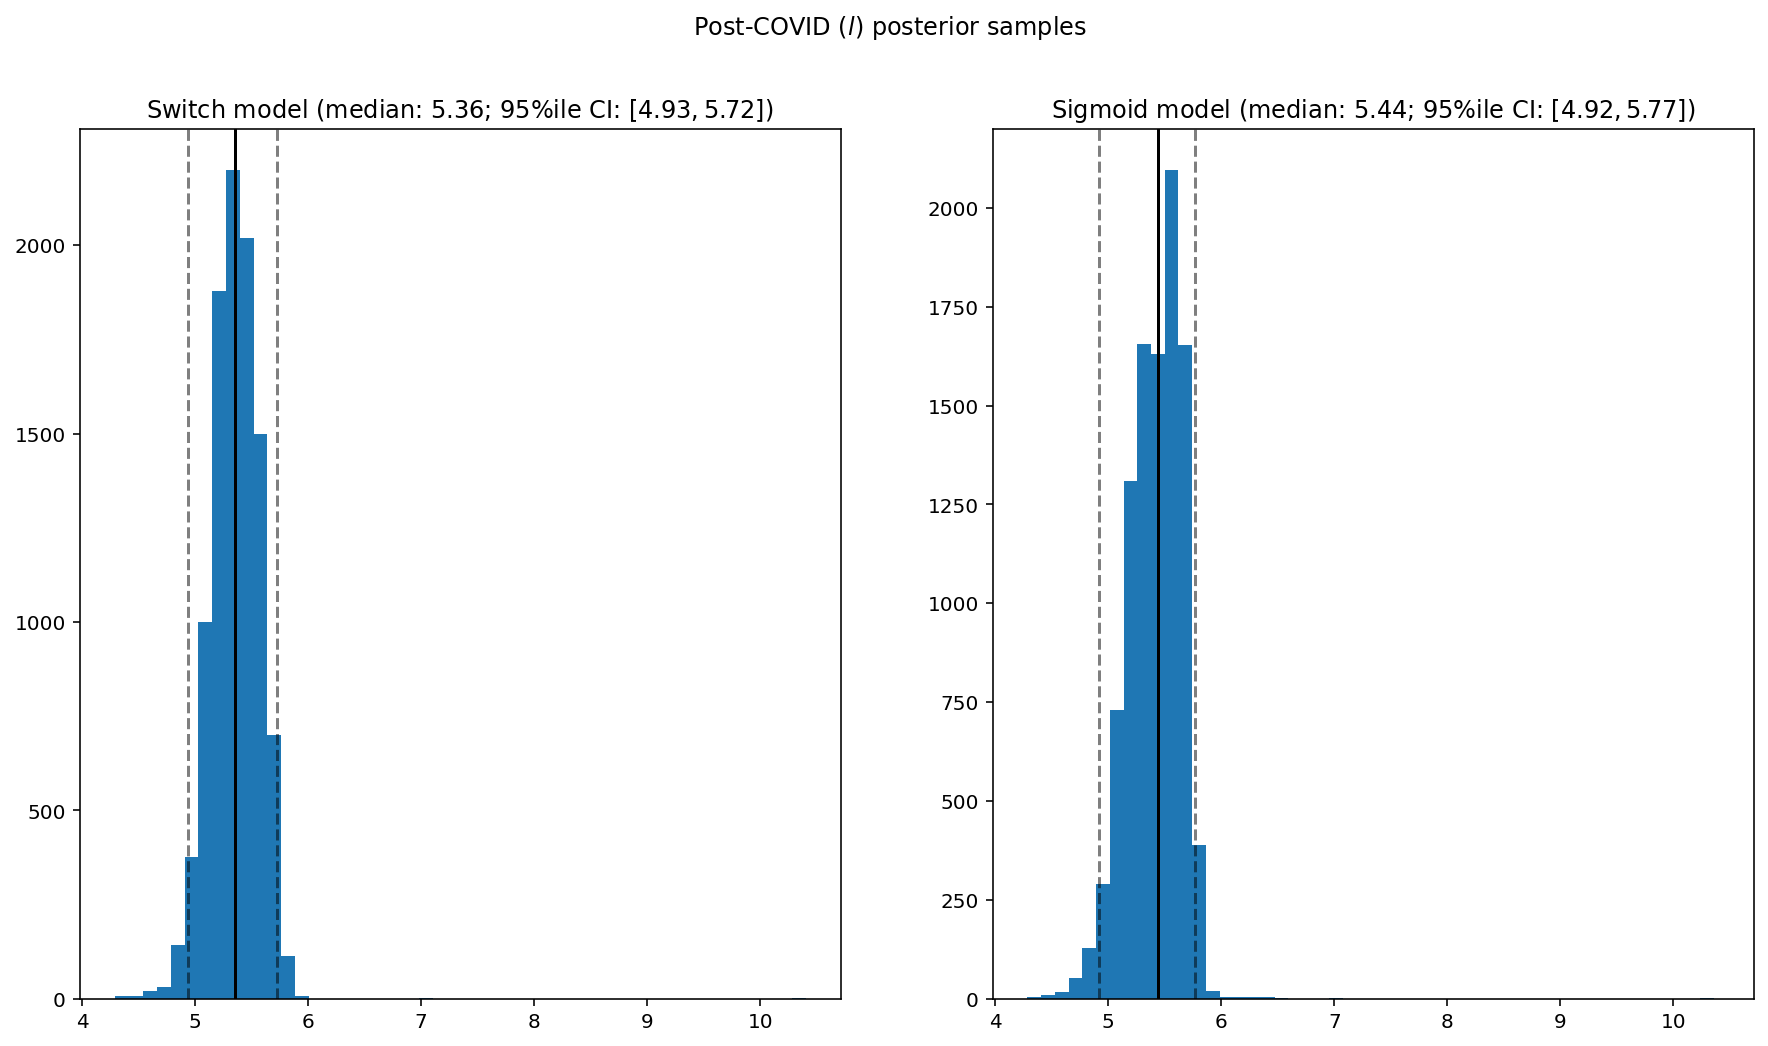

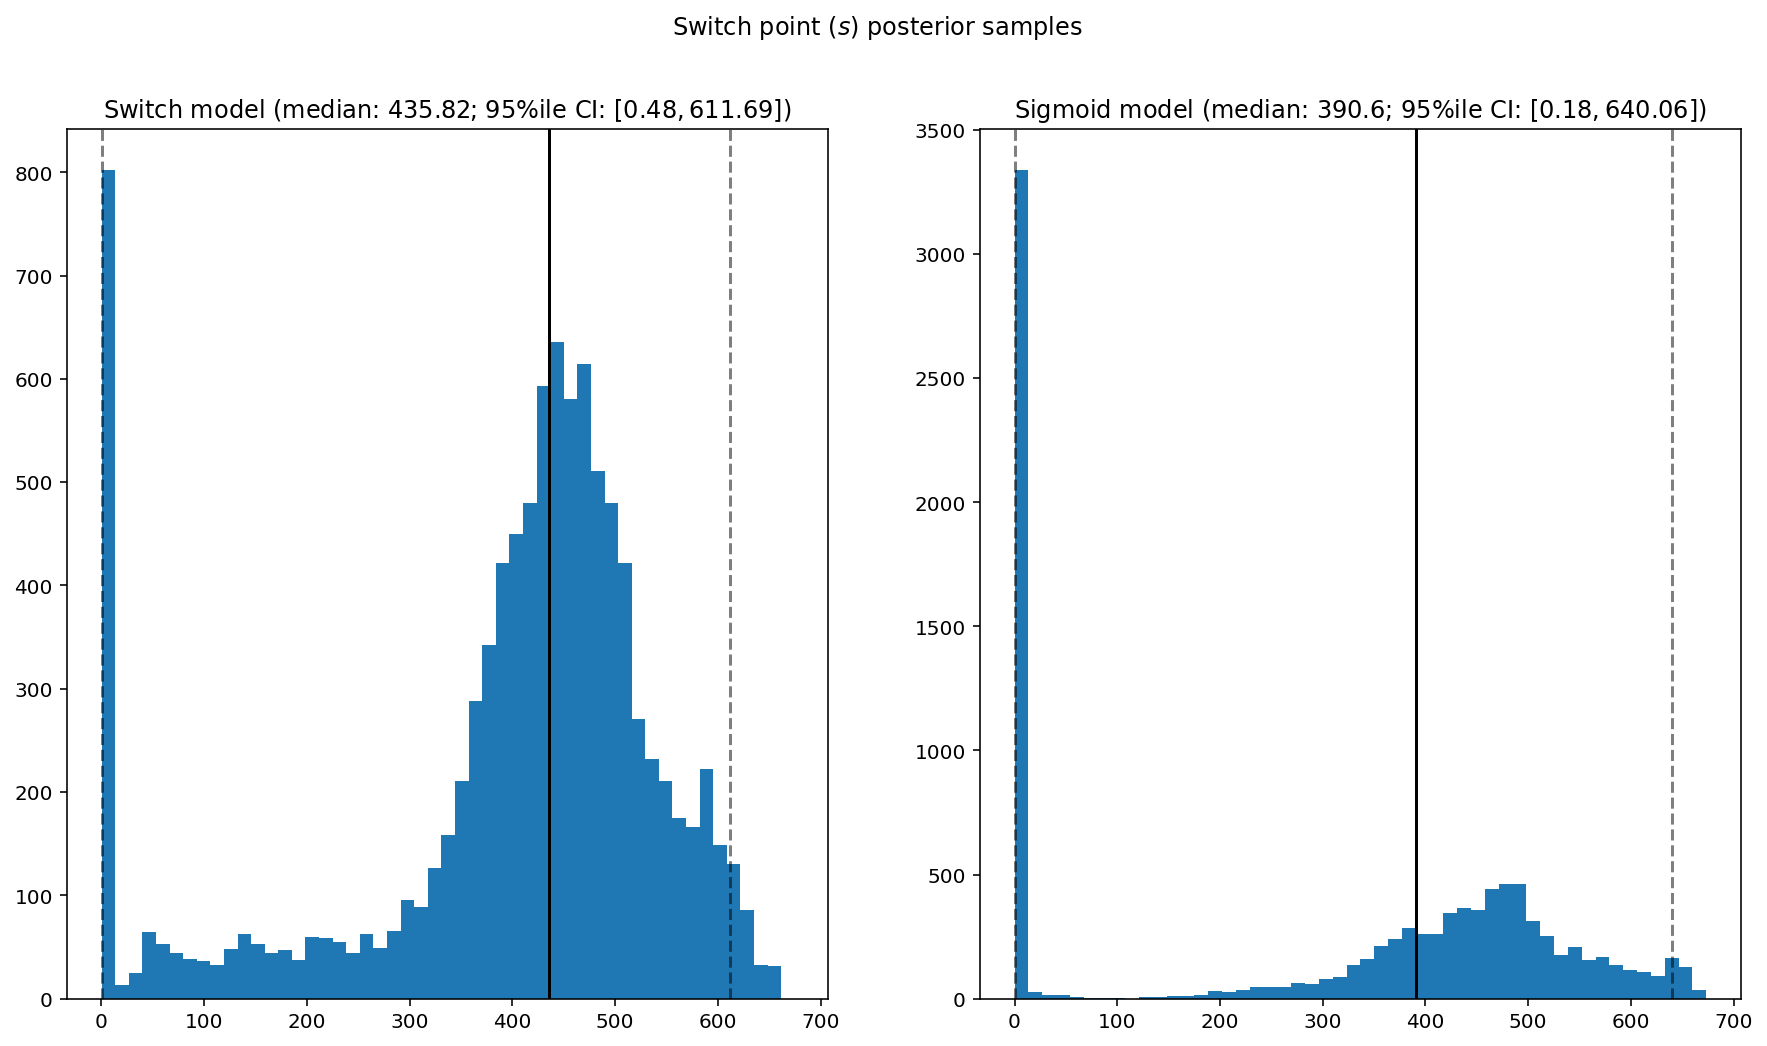

In [12]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Pre-COVID ($e$) posterior samples', pre_covid_rate),
    ('Post-COVID ($l$) posterior samples', post_covid_rate),
    ('Switch point ($s$) posterior samples', date[0] + switchpoint),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()